In [7]:
import numpy as np
import matplotlib.pyplot as plt
import descent
from IPython.html.widgets import interact
from functools import partial
%matplotlib inline

In [8]:
import sklearn
from sklearn.datasets import make_regression

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


# Sparse linear regression

We first generate a toy problem instance:

In [9]:
A, y, x = make_regression(n_samples=20, n_features=50, n_informative=5, coef=True)

We wish to solve the following:
$$ \text{minimize} \quad \| y-Ax \|_2^2 + \lambda \|x\|_1 $$ 

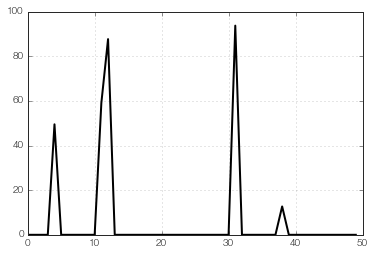

In [10]:
# here is the ground truth sparse vector
plt.plot(x, 'k-')

## Least squares solution

What happens if we solve the system without the sparsity penalty?

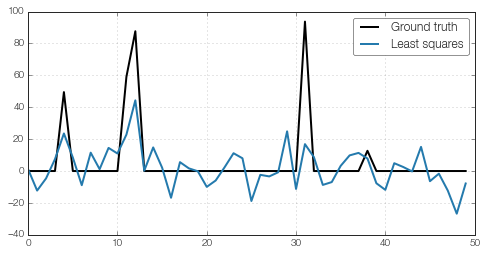

In [11]:
# compute the least squares solution
x_lsq = np.linalg.lstsq(A, y)[0]

# plot the results
plt.figure(figsize=(8,4))
plt.plot(x, 'k-')
plt.plot(x_lsq)
plt.legend(['Ground truth', 'Least squares'])

## Subgradient descent

One way to solve this problem is to go ahead and do gradient descent, using subgradients for the non-smooth term

In [12]:
# squared error objective
def f_df(x):
    err = A.dot(x) - y
    objective = 0.5 * np.linalg.norm(err) ** 2
    gradient = A.T.dot(err)
    return objective, gradient

# squared error + sparsity penalty
def f_df_sparse(x, penalty=1.0):
    # squared error
    obj, grad = f_df(x)
    
    # tack on the sparsity penalty
    obj_sparse = obj + penalty * np.linalg.norm(x, 1)
    grad_sparse = grad + penalty * np.sign(x)
    
    return obj_sparse, grad_sparse

In [13]:
opt_subg = descent.GradientDescent(f_df_sparse, x_lsq, learning_rate=1e-2)
opt_subg.display.every = 1000
opt_subg.run(1e4)

+-------------------+--------------------+-------------------+
|Iteration          | Objective          | Iteration runtime |
+-------------------+--------------------+-------------------+
|              1000 |             409.64 |         106.096 μs|
|              2000 |             382.96 |         111.818 μs|
|              3000 |             366.95 |          107.05 μs|
|              4000 |             354.16 |          113.01 μs|
|              5000 |             344.79 |          113.01 μs|
|              6000 |             339.44 |          107.05 μs|
|              7000 |             335.44 |         148.058 μs|
|              8000 |             331.82 |          122.07 μs|
|              9000 |             328.14 |         118.971 μs|
+-------------------+--------------------+-------------------+
➛ Final objective: 325.9162821693723
➛ Total runtime: 1.37034 s
➛ Per iteration runtime: 137.034 μs +/- 63.1787 μs
➛ All done!



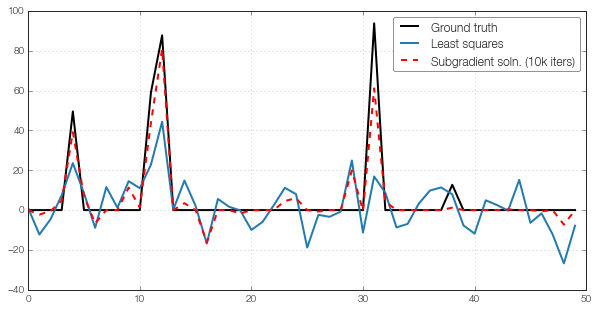

In [14]:
plt.figure(figsize=(10,5))
plt.plot(x, 'k-')
plt.plot(x_lsq)
plt.plot(opt_subg.theta, 'r--')
plt.legend(['Ground truth', 'Least squares', 'Subgradient soln. (10k iters)'])

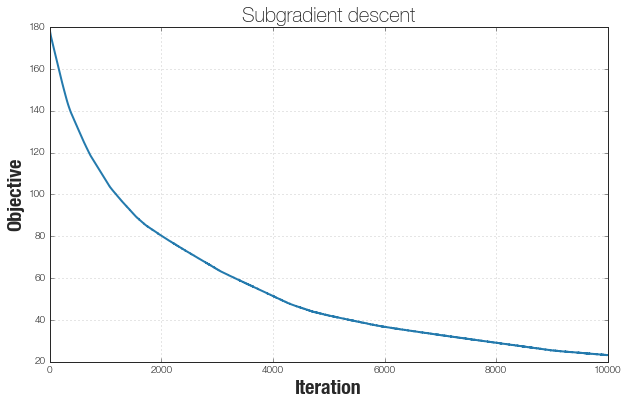

In [15]:
plt.figure(figsize=(10,6))
plt.plot(opt_subg.storage.get('obj') - f_df_sparse(x)[0])
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Objective', fontsize=20)
plt.title('Subgradient descent', fontsize=20)

## ADMM / Proximal methods

In [16]:
opt_admm = descent.ProximalConsensus(x_lsq, tau=(1., 1., 1.))
opt_admm.add('linsys', A, y)
opt_admm.add('sparse', 0.5)
opt_admm.display.every = 100
opt_admm.run(1000)

+-------------------+--------------------+-------------------+
|Iteration          | Objective          | Iteration runtime |
+-------------------+--------------------+-------------------+
|               100 |             374.92 |         611.067 μs|
|               200 |             345.03 |         323.057 μs|
|               300 |             333.61 |         701.189 μs|
|               400 |             325.85 |         371.933 μs|
|               500 |             320.25 |         387.907 μs|
|               600 |             315.13 |         607.014 μs|
|               700 |             310.07 |         361.919 μs|
|               800 |             305.04 |         436.068 μs|
|               900 |             302.54 |         566.006 μs|
+-------------------+--------------------+-------------------+
➛ Final objective: 302.5299016100491
➛ Total runtime: 465.935 ms
➛ Per iteration runtime: 465.935 μs +/- 133.065 μs
➛ All done!



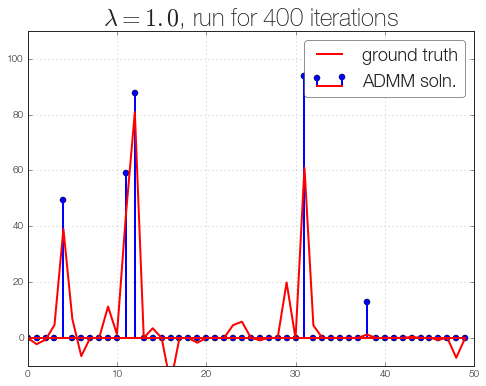

In [17]:
@interact(penalty=(0.1, 1., 0.05), maxiter=(50, 500, 50))
def solve_sparsereg(penalty=1., maxiter=400):
    opt_admm = descent.ProximalConsensus(x_lsq, tau=(2., 1., 1.))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.display = None
    opt_admm.run(maxiter)
    
    plt.figure(figsize=(8,6))
    plt.title('$\lambda = {}$, run for {} iterations'.format(penalty, maxiter), fontsize=24)
    plt.stem(x)
    plt.plot(opt_admm.theta, 'r-')
    plt.ylim(-10, 110)
    plt.legend(['ground truth', 'ADMM soln.'], fontsize=18, loc='upper right')

In [18]:
def compare_algs(penalty, maxiter):
    
    
    # ADMM
    opt_admm = descent.ProximalConsensus(x_lsq, tau=(2.,1.,1.))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.display = None
    opt_admm.obj = lambda theta: f_df_sparse(theta, penalty=penalty)[0]
    opt_admm.run(maxiter=maxiter)
    
    # Subgradient descent
    f_df = partial(f_df_sparse, penalty=penalty)
    opt_subg = descent.GradientDescent(f_df, x_lsq, learning_rate=1e-2)
    opt_subg.display = None
    opt_subg.run(maxiter=maxiter)
    
    return opt_admm, opt_subg

(-5, 400)

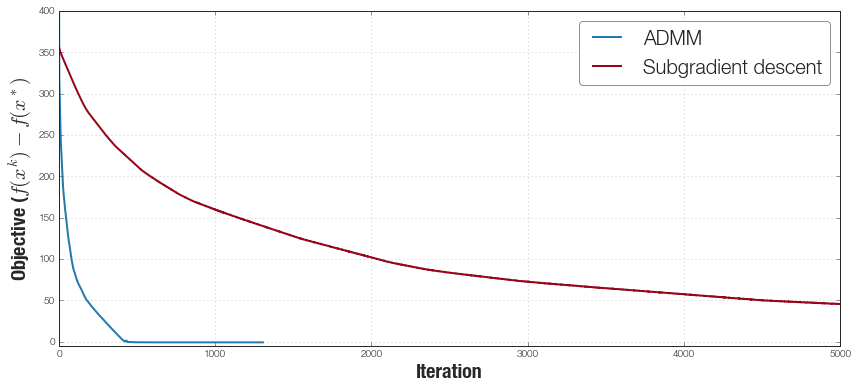

In [19]:
# run the comparison
admm, subg = compare_algs(2., 5000)

# plot the results
fstar = f_df_sparse(x, penalty=2.)[0]
plt.figure(figsize=(14,6))
plt.plot(admm.storage.get('obj')-fstar, lw=2)
plt.plot(subg.storage.get('obj')-fstar, lw=2)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Objective ($f(x^k) - f(x^*)$', fontsize=20)
plt.legend(['ADMM', 'Subgradient descent'], loc=0, frameon=True, fancybox=True, fontsize=20)
plt.ylim(-5,400)